# Foco da Analise, primeiras impressões


Realizar uma clusterização com as seguintes colunas, para compreender quais são os perfis de carros que mais alugados por cada perfil de cliente: 
        'Tipo do cliente', 'Tipo de carro alugado','Quilometragem do carro','Qualidade do carro', 'Tipo de transmissão', 'Combustível', 'Idade do carro', 'Marca do carro'

Realizar com as seguintes colunas, para conseguir uma métrica de receita:
        'Tempo de aluguel', 'Data de início do aluguel', 'Valor do contrato do aluguel','Estado de pagamento','Método de pagamento', 'Contrato cancelado antes do prazo', 'Desconto aplicado no contrato', 'Pagamentos atrasados'

Realizar com as seguintes colunas, para conseguiur encontrar o perfil dos clientes mais valiosos:
        'Tipo do cliente', 'Histórico de contratos anteriores', 'Valor do contrato do aluguel', 'Tempo de aluguel'

Analise do porque ocorrem cancelamentos das compras:
        'Cancelamento da Venda', 'Motivo do Cancelamento (se aplicável)'

Apagar coluna coerente, True para todas as linhas

In [13]:
# Importação das bibliotecas para analise de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from cmdstanpy import CmdStanModel


In [14]:
db_alugueis = pd.read_csv('historico_alugueis.csv')

---------------------------------------------------------

# Limpeza dos dados de cada coluna

In [15]:
#retirnando linhas que contem todos os valores nulos e linhas duplicadas
db_alugueis.dropna(how='all', inplace=True)
db_alugueis = db_alugueis.drop_duplicates()

# Apagando colunas que não serão utilizadas
db_alugueis.drop(columns=['Interações com o suporte'], inplace=True)


In [16]:
# Passando por cada coluna para tratar ela da melhor forma
# Utilizando primeiro o display com unique para entender os valores unicos de cada coluna
# Em seguida realizando o tratamento de acordo com o que foi observado
db_alugueis = db_alugueis.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
db_alugueis = db_alugueis.applymap(lambda x: x.strip().strip() if isinstance(x, str) else x)

# Tratando a coluna 'ID do aluguel'
db_alugueis['ID do cliente'] = db_alugueis['ID do cliente'].astype(int)

# Tratando a coluna 'tipo de carro alugado'

# Tratando a coluna 'Tempo de aluguel'
db_alugueis['Tempo de aluguel'] = db_alugueis['Tempo de aluguel'].astype(int)

#Data de inicio
import re

# Function to convert months in Portuguese-English mix to standard format
# Modify the function to handle non-string (NaN) values safely

def convert_portuguese_date_format(date_str):
    if isinstance(date_str, str):
        # Mapping English month names to their corresponding numbers
        months_mapping = {
            'january': '01', 'february': '02', 'march': '03', 'april': '04', 'may': '05',
            'june': '06', 'july': '07', 'august': '08', 'september': '09', 'october': '10',
            'november': '11', 'december': '12'
        }

        # Pattern to match the format '6 de january de 2022'
        match = re.match(r'(\d{1,2}) de (\w+) de (\d{4})', date_str)
        if match:
            day, month, year = match.groups()
            month_num = months_mapping.get(month.lower(), None)
            if month_num:
                return f'{day}/{month_num}/{year}'
    return date_str  # Return as is if it's not a match or not a string

db_alugueis['Data de início do aluguel'] = db_alugueis['Data de início do aluguel'].apply(convert_portuguese_date_format)
db_alugueis['Data de início do aluguel'] = pd.to_datetime(db_alugueis['Data de início do aluguel'], dayfirst=True, errors='coerce')

# Tratando a coluna 'Data final do aluguel'    
db_alugueis['Data final do aluguel'] = db_alugueis['Data final do aluguel'].apply(convert_portuguese_date_format)
db_alugueis['Data final do aluguel'] = pd.to_datetime(db_alugueis['Data final do aluguel'], dayfirst=True, errors='coerce')

# Tratando a coluna 'Valor do contrato do aluguel'
def clean_valor_do_contrato(value):
    if isinstance(value, str):
        value = value.lower()
        value = value.replace('r$', '').replace('.', '').replace(',', '.').strip()
    return float(value) if value else None

db_alugueis['Valor do contrato do aluguel'] = db_alugueis['Valor do contrato do aluguel'].apply(clean_valor_do_contrato)

#Tratando a coluna Idade do carro
db_alugueis['Idade do carro'] = db_alugueis['Idade do carro'].astype(int)

# Tratando a coluna Satisfação do cliente
db_alugueis['Satisfação do cliente'] = db_alugueis['Satisfação do cliente'].astype(int)

# Tratando Desconto aplicado no contrato
db_alugueis['Desconto aplicado no contrato'] = db_alugueis['Desconto aplicado no contrato'].apply(clean_valor_do_contrato)
                              


---------------------------------------------------------

# Analise Exploratoria

In [17]:
# Para aprofundar um pouco mais nossa analise, vamos separar o database em dois, um com o tipo de cliente B2B e outro com o tipo de cliente B2C
db_alugueis_b2b = db_alugueis[db_alugueis['Tipo do cliente'] == 'b2b']
db_alugueis_b2c = db_alugueis[db_alugueis['Tipo do cliente'] == 'b2c']


### Mesma Analise, pórem separando por tipo de cliente

- Cliente B2B só realizam contratos a cima de 1 ano enquanto B2C realizam contratos de 6 meses ou menos.

### Analise da Receita, supondo que os contratos quitados foram pagos no mês em que o alugel foi iniciado

    Aqui nós temos o objetivo de entender a composição da receita, poara entender como ela está andando, além disso queremos entender qual o perfil de cliente que mais gera receita, e se a empresa está conseguindo fidelizar os clientes que mais geram receita.

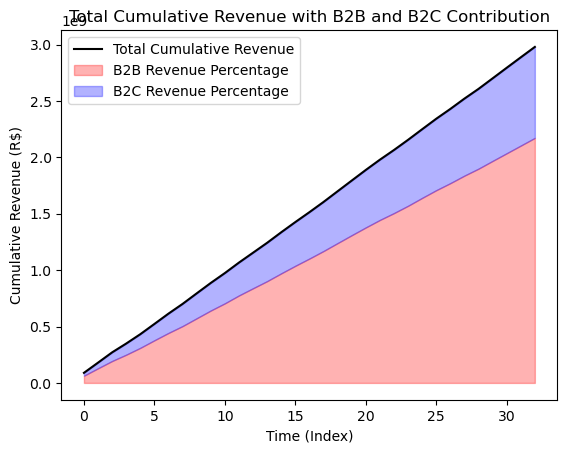

In [18]:
# Analise da receita basica total acumulativa no tempo, desde o começo da empresa, e explorar a porcentagem de receita de cada tipo de cliente
# Plotando o gráfico da Receita cumulativa total ao longo do tempo, analisando a receita mensal, e a porcentagem de receita de cada tipo de cliente
# A coluna valor do contrato, é o valor final fechado, já incluindo desconto e tempo de aluguel
# Plotando o gráfico da Receita cumulativa total ao longo do tempo (um gráfico em baixo do outro)
# Analisando a porcentagem de receita de cada tipo de cliente


# Step 1: Extract month and year from 'Data de início do aluguel'
db_alugueis['Mes'] = db_alugueis['Data de início do aluguel'].dt.month
db_alugueis['Ano'] = db_alugueis['Data de início do aluguel'].dt.year

# Step 2: Filter out rentals that were cancelled
db_alugueis_filtered = db_alugueis[(db_alugueis['Contrato cancelado antes do prazo'] != 'sim') & (db_alugueis['Estado de pagamento'] != 'pendente')]

# Step 3: Group by year, month, and customer type, then calculate total revenue for each group
monthly_revenue = db_alugueis_filtered.groupby(['Mes', 'Ano', 'Tipo do cliente'])['Valor do contrato do aluguel'].sum().reset_index()

# Step 4: Create two separate DataFrames for B2B and B2C
monthly_revenue_b2b = monthly_revenue[monthly_revenue['Tipo do cliente'] == 'b2b'].copy()
monthly_revenue_b2c = monthly_revenue[monthly_revenue['Tipo do cliente'] == 'b2c'].copy()

# Step 5: Calculate cumulative revenue for B2B and B2C clients
monthly_revenue_b2b['Cumulative_B2B'] = monthly_revenue_b2b['Valor do contrato do aluguel'].cumsum()
monthly_revenue_b2c['Cumulative_B2C'] = monthly_revenue_b2c['Valor do contrato do aluguel'].cumsum()

# Step 6: Merge the two DataFrames (B2B and B2C) on Year and Month, fill missing values with 0
merged_revenue = pd.merge(monthly_revenue_b2b[['Ano', 'Mes', 'Cumulative_B2B']],
                          monthly_revenue_b2c[['Ano', 'Mes', 'Cumulative_B2C']],
                          on=['Ano', 'Mes'], how='outer').fillna(0)

# Step 7: Calculate the total cumulative revenue and percentage contributions for each type
merged_revenue['Total_Cumulative'] = merged_revenue['Cumulative_B2B'] + merged_revenue['Cumulative_B2C']
merged_revenue['Percentage_B2B'] = (merged_revenue['Cumulative_B2B'] / merged_revenue['Total_Cumulative']) * 100
merged_revenue['Percentage_B2C'] = (merged_revenue['Cumulative_B2C'] / merged_revenue['Total_Cumulative']) * 100

# Plot total cumulative revenue
plt.plot(merged_revenue['Total_Cumulative'], label='Total Cumulative Revenue', color='black')

# Shade the area for B2B and B2C percentages
plt.fill_between(range(len(merged_revenue)), 0, merged_revenue['Total_Cumulative'] * (merged_revenue['Percentage_B2B'] / 100), 
                 color='red', alpha=0.3, label='B2B Revenue Percentage')
plt.fill_between(range(len(merged_revenue)), 
                 merged_revenue['Total_Cumulative'] * (merged_revenue['Percentage_B2B'] / 100), 
                 merged_revenue['Total_Cumulative'], color='blue', alpha=0.3, label='B2C Revenue Percentage')

plt.title('Total Cumulative Revenue with B2B and B2C Contribution')
plt.xlabel('Time (Index)')
plt.ylabel('Cumulative Revenue (R$)')
plt.legend()
plt.show()


- Nota-se que a maior parte da Receita de origina de contratos de clientes do tipo B2B, entretanto a maior parte dos contratos são de clientes do tipo B2C, o que indica que os contratos de B2B são mais valiosos.

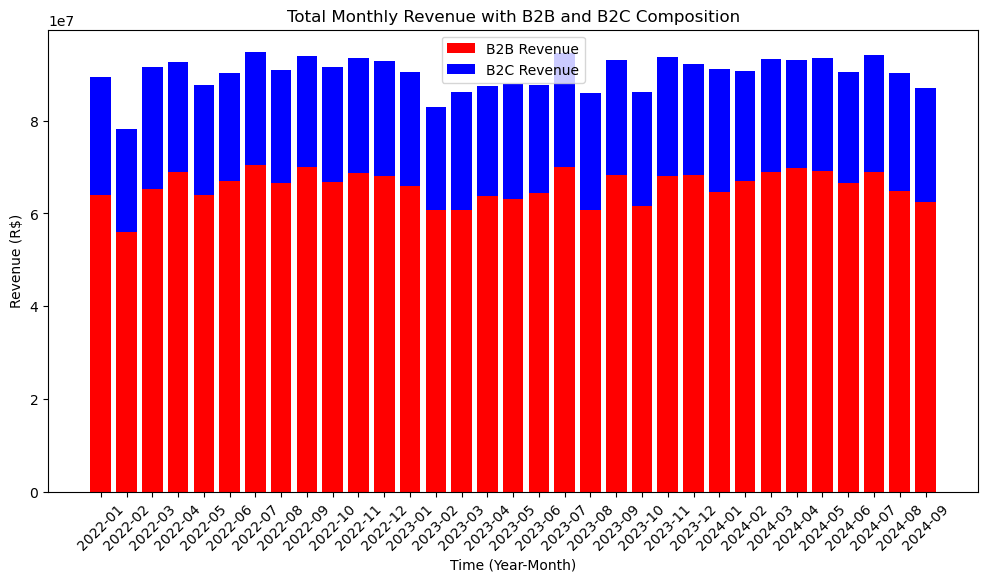

In [19]:
# Agora vamos analisar a receita mensal durante a vida da empresa, entendendo a composição da receita de cada tipo de cliente

# Step 3: Pivot the data to have B2B and B2C revenues as separate columns
pivot_revenue = monthly_revenue.pivot_table(index=['Ano', 'Mes'], columns='Tipo do cliente', values='Valor do contrato do aluguel', fill_value=0)

# Combine Year and Month into a single string column to use as the x-axis
pivot_revenue['Year_Month'] = pivot_revenue.index.get_level_values('Ano').astype(str) + '-' + pivot_revenue.index.get_level_values('Mes').astype(str).str.zfill(2)

# Step 4: Plot the stacked bar chart for monthly revenue
plt.figure(figsize=(12, 6))

# Plotting B2B and B2C as stacked bars, using the combined 'Year_Month' for the x-axis
plt.bar(pivot_revenue['Year_Month'], pivot_revenue['b2b'], label='B2B Revenue', color='red')
plt.bar(pivot_revenue['Year_Month'], pivot_revenue['b2c'], bottom=pivot_revenue['b2b'], label='B2C Revenue', color='blue')

plt.title('Total Monthly Revenue with B2B and B2C Composition')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Revenue (R$)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()


- Percebe-se que a maior fonte de receita é oriunda de contratos B2B, que são mais longos e valem mais, agora vamos analisar a demanda para ver como estão distribuidos

### Analise da demanda, Vamos entender quantos carros são alugados por mês por cada perfil de cliente

    Aqui queremos realizar uma conexão com a ánalise do faturamento, Queremos entender o ticket médio de clientes B2B e B2C, e entender se a empresa está conseguindo fidelizar os clientes que mais geram receita.
    Além disso, queremos entneder como a empresa está gerindo a frota, como os contratos estão sendo distribuidos, e se a empresa está conseguindo atender a demanda, e ao mesmo tempo e ela está com um estoque muito alto, o que pode ser um problema, pois estara perdendo muito poder de barganha com os clientes B2B, que são contratos mais longos, que caso não sejam renovados, podem gerar um grande prejuizo, especialmente se não existir uma demanda de clientes B2C para suprir.
    
    Será utilizado o modelo de previsão do facebook, o Prophet, ele basicamnte é uma ferramenta que captura varios padroes dentro de uma série temporal.

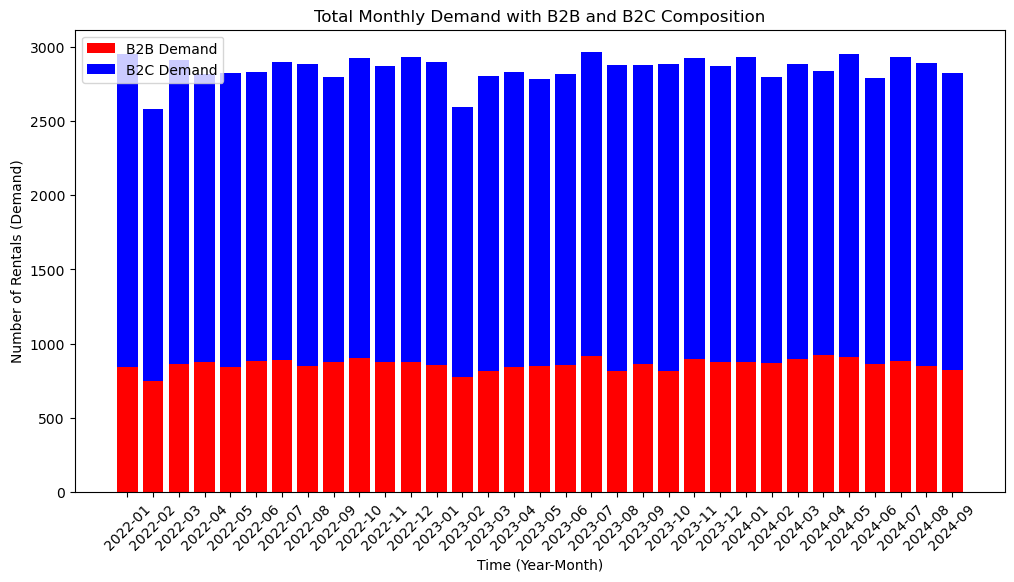

In [20]:
# Step 1: Filter out rentals where the payment is pending and rentals that were cancelled
db_alugueis_filtered = db_alugueis[db_alugueis['Contrato cancelado antes do prazo'] != 'sim']

# Step 2: Group the data by 'Year', 'Month', and 'Tipo do cliente' and count the number of rentals (demand)
monthly_demand = db_alugueis_filtered.groupby(['Ano', 'Mes', 'Tipo do cliente']).size().reset_index(name='Demand')

# Step 3: Pivot the data to have B2B and B2C demand as separate columns
pivot_demand = monthly_demand.pivot_table(index=['Ano', 'Mes'], columns='Tipo do cliente', values='Demand', fill_value=0)

# Combine Year and Month into a single string column to use as the x-axis
pivot_demand['Year_Month'] = pivot_demand.index.get_level_values('Ano').astype(str) + '-' + pivot_demand.index.get_level_values('Mes').astype(str).str.zfill(2)

# Step 4: Plot the stacked bar chart for monthly demand
plt.figure(figsize=(12, 6))

# Plotting B2B and B2C demand as stacked bars, using the combined 'Year_Month' for the x-axis
plt.bar(pivot_demand['Year_Month'], pivot_demand['b2b'], label='B2B Demand', color='red')
plt.bar(pivot_demand['Year_Month'], pivot_demand['b2c'], bottom=pivot_demand['b2b'], label='B2C Demand', color='blue')

plt.title('Total Monthly Demand with B2B and B2C Composition')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Number of Rentals (Demand)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()


#### Agora iremos relizar um modelo de previsão da demanda para o próximo ano

Será utilizado o modelo do facebook Prophet, que é um modelo de previsão de séries temporais, utilizado para prever séries temporais com sazonalidade e com tendência.

23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:14:48 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

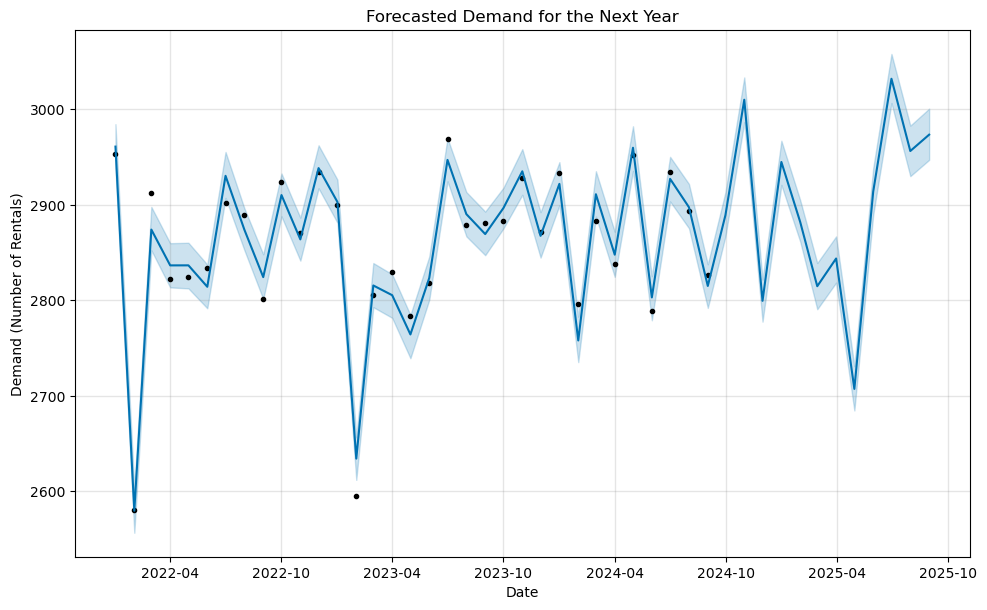

In [21]:
from prophet import Prophet

# Step 1: Prepare the data (aggregate demand by month for both B2B and B2C)
db_alugueis_filtered = db_alugueis[
    (db_alugueis['Contrato cancelado antes do prazo'] != 'sim')
]

# Aggregate demand by month (count the rentals per month)
monthly_demand = db_alugueis_filtered.groupby(['Ano', 'Mes']).size().reset_index(name='Demand')

# Create a 'ds' column (date format) for Prophet and a 'y' column (demand)
monthly_demand['ds'] = pd.to_datetime(monthly_demand['Ano'].astype(str) + '-' + monthly_demand['Mes'].astype(str) + '-01')
monthly_demand['y'] = monthly_demand['Demand']

# Step 2: Train the Prophet model on historical demand data
model = Prophet()
model.fit(monthly_demand[['ds', 'y']])

# Step 3: Forecast the next 12 months
future = model.make_future_dataframe(periods=12, freq='M')  # Forecast next 12 months
forecast = model.predict(future)

# Step 4: Visualize the forecasted demand along with historical demand
plt.figure(figsize=(10, 6))
model.plot(forecast)
plt.title('Forecasted Demand for the Next Year')
plt.xlabel('Date')
plt.ylabel('Demand (Number of Rentals)')
plt.show()




- Bola preta: dados reais antigos da demanda de cada mês
- Linha Azul: Curva esperada pelo modelo dos dados antigos e dos dados futuros.
- Sombra Azul: Intervalo de confiança, dentro dele a confiança dos dados futuros estarem corretas é de 95%

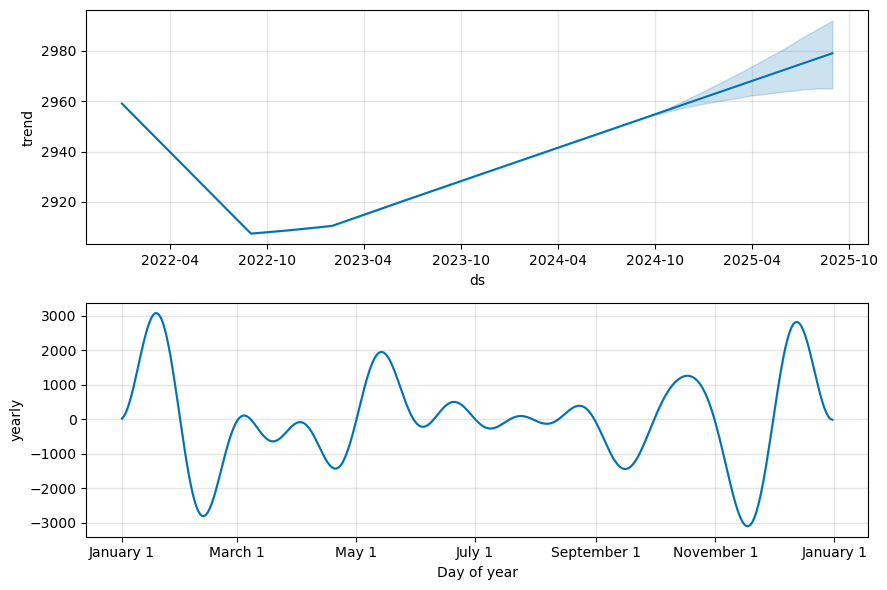

In [22]:
model.plot_components(forecast)
plt.show()


- Trend: Tendencia eserada para a demanda
- Yearly Seasonality: Mostra a variação da demanda durante o Ano

23:17:08 - cmdstanpy - INFO - Chain [1] start processing
23:17:09 - cmdstanpy - INFO - Chain [1] done processing
23:17:09 - cmdstanpy - INFO - Chain [1] start processing
23:17:09 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

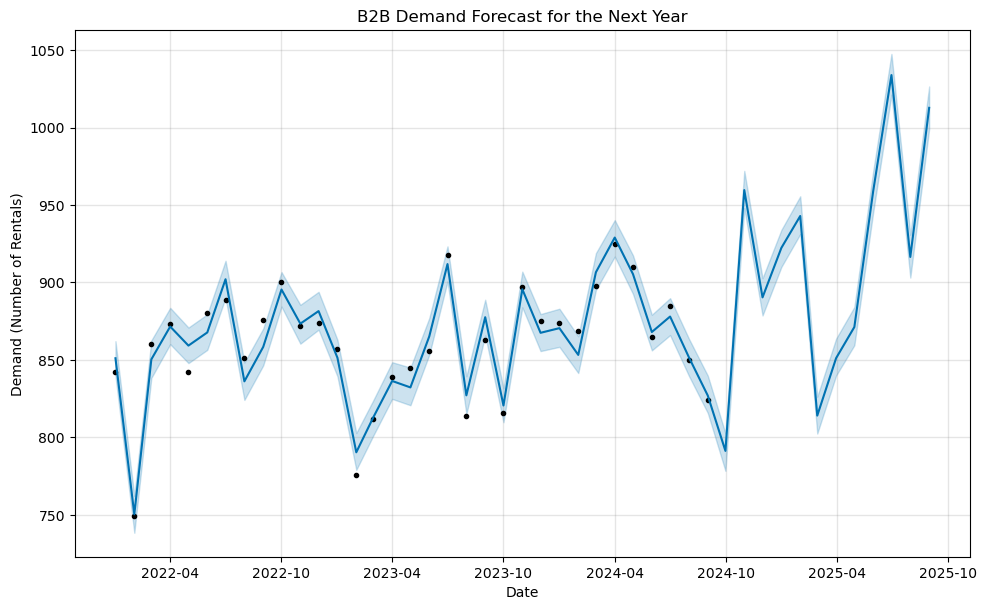

<Figure size 1000x600 with 0 Axes>

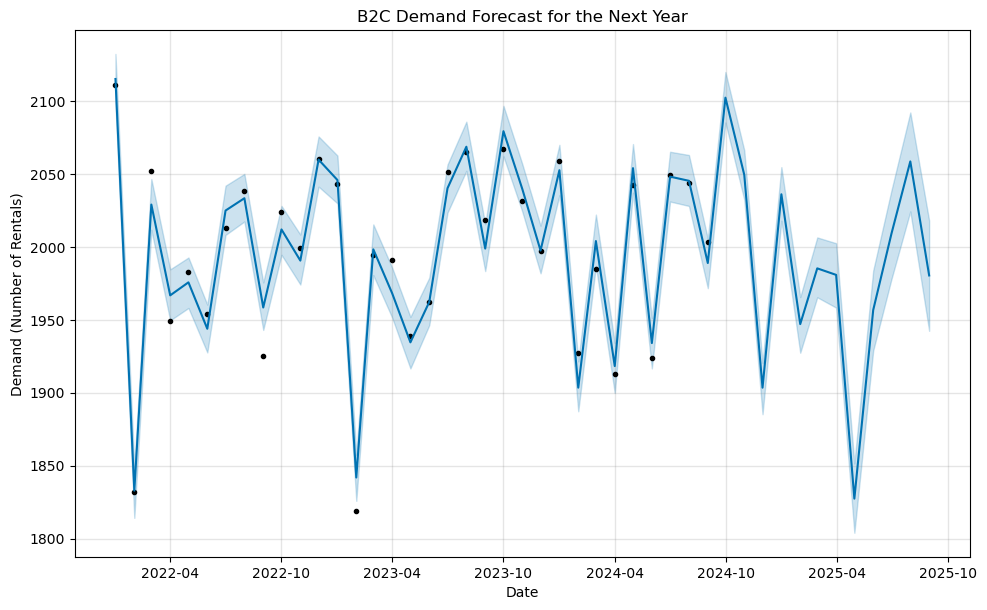

In [25]:
# Step 1: Prepare the data by filtering out canceled contracts
db_alugueis_filtered = db_alugueis[
    (db_alugueis['Contrato cancelado antes do prazo'] != 'sim')
]

# Step 2: Forecast for B2B
# Filter the data for B2B clients
monthly_demand_b2b = db_alugueis_filtered[db_alugueis_filtered['Tipo do cliente'] == 'b2b'].groupby(['Ano', 'Mes']).size().reset_index(name='Demand')

# Create 'ds' column for Prophet and 'y' column for demand
monthly_demand_b2b['ds'] = pd.to_datetime(monthly_demand_b2b['Ano'].astype(str) + '-' + monthly_demand_b2b['Mes'].astype(str) + '-01')
monthly_demand_b2b['y'] = monthly_demand_b2b['Demand']

# Train the Prophet model for B2B
model_b2b = Prophet()
model_b2b.fit(monthly_demand_b2b[['ds', 'y']])

# Forecast for the next 12 months for B2B
future_b2b = model_b2b.make_future_dataframe(periods=12, freq='M')
forecast_b2b = model_b2b.predict(future_b2b)

# Step 3: Forecast for B2C
# Filter the data for B2C clients
monthly_demand_b2c = db_alugueis_filtered[db_alugueis_filtered['Tipo do cliente'] == 'b2c'].groupby(['Ano', 'Mes']).size().reset_index(name='Demand')

# Create 'ds' column for Prophet and 'y' column for demand
monthly_demand_b2c['ds'] = pd.to_datetime(monthly_demand_b2c['Ano'].astype(str) + '-' + monthly_demand_b2c['Mes'].astype(str) + '-01')
monthly_demand_b2c['y'] = monthly_demand_b2c['Demand']

# Train the Prophet model for B2C
model_b2c = Prophet()
model_b2c.fit(monthly_demand_b2c[['ds', 'y']])

# Forecast for the next 12 months for B2C
future_b2c = model_b2c.make_future_dataframe(periods=12, freq='M')
forecast_b2c = model_b2c.predict(future_b2c)

# Step 4: Plot the forecast for B2B
plt.figure(figsize=(10, 6))
model_b2b.plot(forecast_b2b)
plt.title('B2B Demand Forecast for the Next Year')
plt.xlabel('Date')
plt.ylabel('Demand (Number of Rentals)')
plt.show()

# Step 5: Plot the forecast for B2C
plt.figure(figsize=(10, 6))
model_b2c.plot(forecast_b2c)
plt.title('B2C Demand Forecast for the Next Year')
plt.xlabel('Date')
plt.ylabel('Demand (Number of Rentals)')
plt.show()


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Function to evaluate model performance
def evaluate_model_performance(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, mse, rmse, mape

# Step 1: Evaluate Total Demand Model
# Predict on historical data for total demand
historical_total = model.predict(monthly_demand[['ds']])

# Calculate performance metrics for total demand
mae_total, mse_total, rmse_total, mape_total = evaluate_model_performance(
    monthly_demand['y'], historical_total['yhat']
)

print(f"Total Demand Model Performance:")
print(f"MAE: {mae_total}")
print(f"MSE: {mse_total}")
print(f"RMSE: {rmse_total}")
print(f"MAPE: {mape_total}%\n")

# Step 2: Evaluate B2B Demand Model
# Predict on historical data for B2B demand
historical_b2b = model_b2b.predict(monthly_demand_b2b[['ds']])

# Calculate performance metrics for B2B demand
mae_b2b, mse_b2b, rmse_b2b, mape_b2b = evaluate_model_performance(
    monthly_demand_b2b['y'], historical_b2b['yhat']
)

print(f"B2B Demand Model Performance:")
print(f"MAE: {mae_b2b}")
print(f"MSE: {mse_b2b}")
print(f"RMSE: {rmse_b2b}")
print(f"MAPE: {mape_b2b}%\n")

# Step 3: Evaluate B2C Demand Model
# Predict on historical data for B2C demand
historical_b2c = model_b2c.predict(monthly_demand_b2c[['ds']])

# Calculate performance metrics for B2C demand
mae_b2c, mse_b2c, rmse_b2c, mape_b2c = evaluate_model_performance(
    monthly_demand_b2c['y'], historical_b2c['yhat']
)

print(f"B2C Demand Model Performance:")
print(f"MAE: {mae_b2c}")
print(f"MSE: {mse_b2c}")
print(f"RMSE: {rmse_b2c}")
print(f"MAPE: {mape_b2c}%")


Total Demand Model Performance:
MAE: 14.796622619735595
MSE: 323.0028714182069
RMSE: 17.972280640425325
MAPE: 0.5210558059399509%

B2B Demand Model Performance:
MAE: 7.6912986460957224
MSE: 86.06125610380548
RMSE: 9.27692061536615
MAPE: 0.8967864281040605%

B2C Demand Model Performance:
MAE: 10.259904178930135
MSE: 174.46211904539442
RMSE: 13.20841092052312
MAPE: 0.5184486692561843%
